# Wavefront propagation simulation tutorial - Case 1

L.Samoylova <liubov.samoylova@xfel.eu>, A.Buzmakov <buzmakov@gmail.com>

Tutorial course on Wavefront Propagation Simulations, 28/11/2013, European XFEL, Hamburg.
Updated for using new syntax 28/11/2015

Wave optics software is based on SRW core library <https://github.com/ochubar/SRW>, available through WPG interactive framework <https://github.com/samoylv/WPG>

## Propagation through CRLs optics

### Import modules

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [16]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy
import pylab

import cPickle as pickle
import errno

#import SRW core functions
from wpg.srwlib import srwl, srwl_opt_setup_CRL, SRWLOptD, SRWLOptA, SRWLOptC, SRWLOptT

#import SRW auxiliary functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh, plot_1d, plot_2d

from wpg.wpg_uti_wf import propagate_wavefront
from wpg.wpg_uti_oe import show_transmission

#from wpg.useful_code.wfrutils import propagate_wavefront

#Import base wavefront class
from wpg import Wavefront

#Import base beamline class and OE wrappers
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
from wpg.optical_elements import         Drift,Aperture,    Lens,Mirror_elliptical,WF_dist,calculateOPD

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy

pylab.ion()

### Use or not new syntax

In [3]:
NEW_SYNTAX = True

### Define auxiliary functions

In [4]:
def calculate_source_fwhm(ekev, theta_fwhm):
    """
    Calculate source size from photon energy and FWHM angular divergence
    
    :param evev: Energy in keV
    :param theta_fwhm: theta_fwhm [units?] 
    """
    wl = 12.39e-10/ekev
    k = 2 * numpy.sqrt(2*numpy.log(2))
    theta_sigma = theta_fwhm /k
    sigma0 = wl /(2*numpy.pi*theta_sigma)
    return sigma0*k

def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011
    
    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * numpy.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

def defineOPD(opTrErMirr, mdatafile, ncol, delim, Orient, theta, scale):
    """
    Define optical path difference (OPD) from mirror profile, i.e. ill the struct opTrErMirr
    
    :params mdatafile: an ascii file with mirror profile data
    :params ncol: number of columns in the file
    :params delim: delimiter between numbers in an row, can be space (' '), tab '\t', etc
    :params orient: mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :params theta: incidence angle
    :params scale: scaling factor for the mirror profile    
    """
    heightProfData = numpy.loadtxt(mdatafile).T
    AuxTransmAddSurfHeightProfileScaled(opTrErMirr, heightProfData, Orient, theta, scale)
    pylab.figure()
    plot_1d(heightProfData,'profile from ' + mdatafile,'x (m)', 'h (m)')

In [5]:
def calc_sampling(zoom,mf):
    """
    This function calculates sampling.
    :param zoom: range zoom
    :param mf: modification factor for step, i.e. dx1=mf*dx0
    
    :return: sampling.
    """
    sampling = zoom/mf; 
    print 'zoom:{:.1f}; mod_factor:{:.1f}; sampling:{:.1f}'.format(zoom, mf, sampling)
    return sampling

In [6]:
def _save_object(obj, file_name):
    """
    Save any python object to file.
    
    :param: obj : - python objest to be saved
    :param: file_name : - output file, wil be overwrite if exists
    """
    with open(file_name,'w') as f:
        pickle.dump(obj, f)

def _load_object(file_name):
    """
    Save any python object to file.
    
    :param: file_name : - output file, wil be overwrite if exists
    :return: obj : - loaded pthon object
    """
    res = None
    with open(file_name,'r') as f:
        res = pickle.load(f)
        
    return res

def mkdir_p(path):
    """
    Create directory with subfolders (like Linux mkdir -p)
    
    :param path: Path to be created
    """
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise
            
def create_CRL(directory=None, voids_params=None, *args, **keywrds):
    """
    This function build CLR or load it from file if it was created beforehand.
    Out/input filename builded as sequence of function parameters.
    
    Adiitinal parameters (*args) passed to srwlib.srwl_opt_setup_CRL function
    
    :param directory: output directory to save file.
    :param voids_params: void params to build CRL and construct unique file name
    :return: SRWL CRL object
    """
    if not isinstance(voids_params,tuple):
        raise TypeError('Voids_params must be tuple')
        
    file_name = '_'.join([str(a) for a in args[:-1]])
    subdir_name = '_'.join([str(v) for v in voids_params])
    if directory is None:
        full_path = os.path.join(subdir_name,file_name+'.pkl')
    else:
        full_path = os.path.join(directory, subdir_name, file_name+'.pkl')
    
    if  os.path.isfile(full_path):
        print 'Found file {}. CLR will be loaded from file'.format(full_path)
        res = _load_object(full_path)
        return res
    else:
        print 'CLR file NOT found. CLR will be recalculated and saved in file {}'.format(full_path)
        res = srwlib.srwl_opt_setup_CRL(*args)
        mkdir_p(os.path.dirname(full_path))
        _save_object(res, full_path)
        return res 

def create_CRL1(directory,file_name,*args, **keywrds):
    """
    This function build CLR or load it from file.
    Out/input filename builded as sequence of function parameters.
    Adiitinal parameters (*args) passed to srwlib.srwl_opt_setup_CRL function
    
    :param directory: output directory
    :param fiel_name: CRL file name
    :return: SRWL CRL object
    """
        
    full_path = os.path.join(directory, file_name+'.pkl')
    
    if  os.path.isfile(full_path):
        print 'Found file {}. CLR will be loaded from file'.format(full_path)
        res = _load_object(full_path)
        return res
    else:
        print 'CLR file NOT found. CLR will be recalculated and saved in file {}'.format(full_path)
        res = srwl_opt_setup_CRL(*args)
        mkdir_p(os.path.dirname(full_path))
        _save_object(res, full_path)
        return res 


### Defining initial wavefront and writing electric field data to h5-file

*****defining initial wavefront and writing electric field data to h5-file...
sigX, waist_fwhm [um], far field theta_fwhms [urad]: 11.4997882319 27.0799318422 2.99702906039
save hdf5: g6_742kev.h5
done
FWHMx [mm]: 0.69007789015
FWHMy [mm]: 0.69007789015
Coordinates of center, [mm]: 0.00584811771314 0.00584811771314
stepX, stepY [um]: 11.6962354263 11.6962354263 

Total power (integrated over full range): 54.4369 [GW]
Peak power calculated using FWHM:         52.4365 [GW]
Max irradiance: 96.7817 [GW/mm^2]
FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: 0.69007789015 2.93650166021


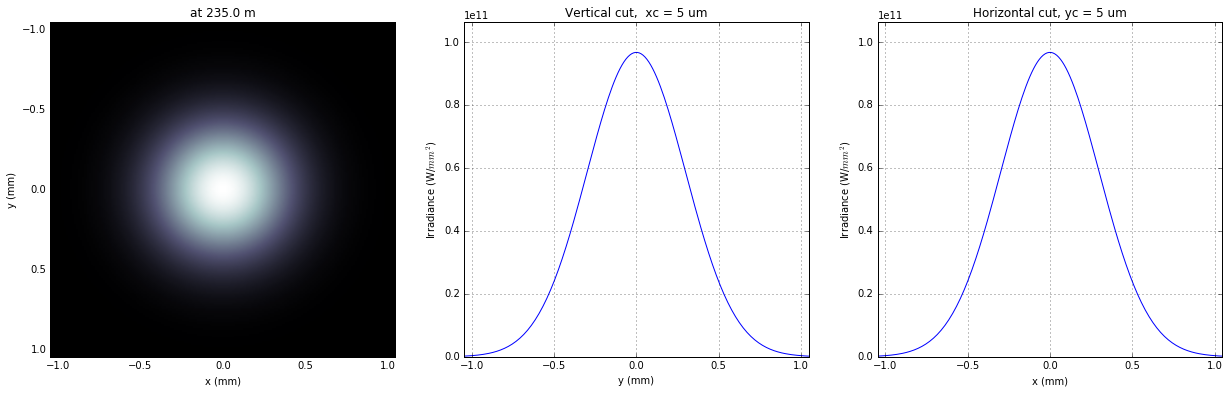

In [7]:
print('*****defining initial wavefront and writing electric field data to h5-file...')

strInputDataFolder ='data_common' # sub-folder name for common input  data 
strDataFolderName = 'Tutorial_case_1' # output data sub-folder name 
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

d2crl1_sase1 = 235.0 # Distance to CRL1 on SASE1 [m]
d2crl1_sase2 = 235.0 # Distance to CRL1 on SASE2 [m]
d2m1_sase1 = 246.5  # Distance to mirror1 on SASE1 [m]
d2m1_sase2 = 290.0  # Distance to mirror1 on SASE2 [m]

ekev = 6.742 # Energy [keV] 
thetaOM = 2.5e-3       # @check!

# e-bunch charge, [nC]; total pulse energy, J
#qnC = 0.02;pulse_duration = 1.7e-15;pulseEnergy = 0.08e-3   
#coh_time = 0.24e-15

qnC = 0.1; # e-bunch charge, [nC]
pulse_duration = 9.e-15; 
pulseEnergy = 0.5e-3; # total pulse energy, J
coh_time = 0.24e-15


d2m1 = d2m1_sase2
d2crl1 = d2crl1_sase2

z1 = d2crl1
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*sqrt(2*log(2))
sigX = 12.4e-10*k/(ekev*4*pi*theta_fwhm) 
print 'sigX, waist_fwhm [um], far field theta_fwhms [urad]:', sigX*1e6, sigX*k*1e6, theta_fwhm*1e6
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size
np=180

wfr0 = build_gauss_wavefront_xy(np, np, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,sigX, sigX, z1,
                                pulseEn=pulseEnergy, pulseTau=coh_time/sqrt(2),
                                repRate=1/(sqrt(2)*pulse_duration))    
    
mwf = Wavefront(wfr0)
ip = floor(ekev)
frac = numpy.floor((ekev - ip)*1e3)
ename = str(int(ip))+'_'+str(int(frac))+'kev'
fname0 = 'g' + ename
ifname = os.path.join(strDataFolderName,fname0+'.h5')
print('save hdf5: '+fname0+'.h5')
mwf.store_hdf5(ifname)
print('done')
pow_x=plot_wfront(mwf, 'at '+str(z1)+' m',False, False, 1e-5,1e-5,'x', True, saveDir='./'+strDataFolderName)
pylab.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
fwhm_x = calculate_fwhm_x(mwf);fwhm_y = calculate_fwhm_y(mwf)
print 'FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist:',fwhm_x*1e3,fwhm_x/z1*1e6, 

In [8]:
print pow_x[:,1].max()
print 'I_o %g [GW/mm^2]'    %(pow_x[:,1].max()*1e-9) 
print 'peak power %g [GW]'  %(pow_x[:,1].max()*1e-9*1e6*2*pi*(fwhm_x/2.35)**2)

96781656064.0
I_o 96.7817 [GW/mm^2]
peak power 52.4365 [GW]


### Defining optical beamline(s) 

*****Defining optical beamline(s) ...
Found file Tutorial_case_1/opd_CRL1_1_R3530_6_742kev.pkl. CLR will be loaded from file
Found file Tutorial_case_1/opd_CRL2_8_R3530_6_742kev.pkl. CLR will be loaded from file
zoom:0.0; mod_factor:0.0; sampling:2.0


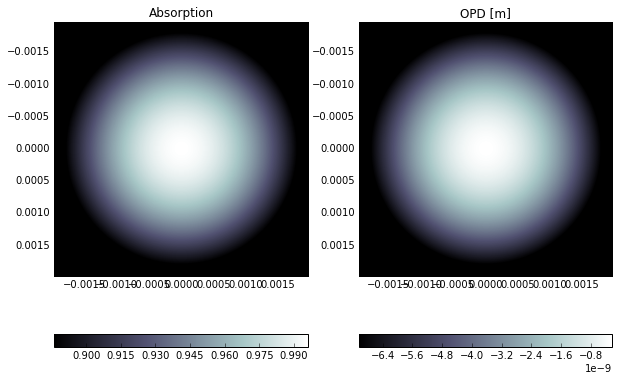

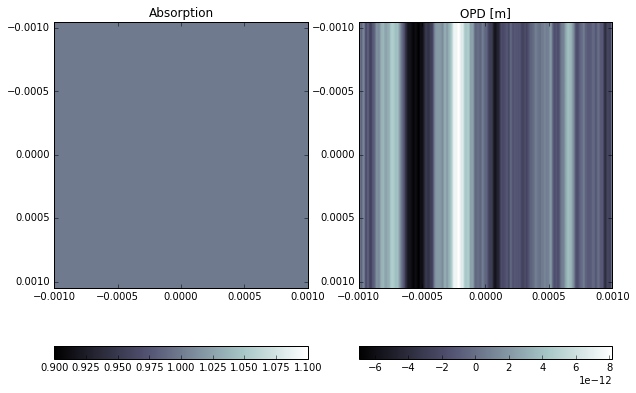

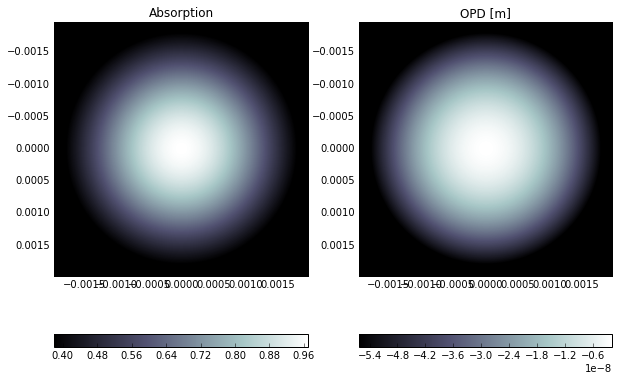

In [20]:
print('*****Defining optical beamline(s) ...')
#***********CRLs
nCRL1 = 1 #number of lenses, collimating
nCRL2 = 8
delta = 7.511e-06
attenLen = 3.88E-3
diamCRL = 3.58e-03 #CRL diameter
#rMinCRL = 3.3e-03  #CRL radius at the tip of parabola [m]
rMinCRL = 2*delta*z1/nCRL1
wallThickCRL = 30e-06 #CRL wall thickness [m]

#Generating a perfect 2D parabolic CRL:
#opCRL1 = srwlib.srwl_opt_setup_CRL(3, delta, attenLen, 1, 
#                                  diamCRL, diamCRL, rMinCRL, nCRL, wallThickCRL, 0, 0)
opCRL1 = create_CRL1(strDataFolderName,
                     'opd_CRL1_'+str(nCRL1)+'_R'+str(int(rMinCRL*1e6))+'_'+ename,
                     3,delta,attenLen,1,diamCRL,diamCRL,rMinCRL,nCRL1,wallThickCRL,0,0,None)
#opCRL1 = srwl_opt_setup_CRL(3, delta, attenLen, 1, 
#                                  diamCRL, diamCRL, rMinCRL, nCRL1, wallThickCRL, 0, 0)
#Saving transmission data to file
#AuxSaveOpTransmData(opCRL1, 3, os.path.join(os.getcwd(), strDataFolderName, "opt_path_dif_CRL1.dat"))
opCRL2 = create_CRL1(strDataFolderName,
                     'opd_CRL2_'+str(nCRL2)+'_R'+str(int(rMinCRL*1e6))+'_'+ename,
                     3,delta,attenLen,1,diamCRL,diamCRL,rMinCRL,nCRL2,wallThickCRL,0,0,None)

scale = 1     #5 mirror profile scaling factor 
horApM1 = 0.8*thetaOM

#d2crl2_sase1 = 904.0
d2crl2_sase2 = 931.0

d2exp_sase1 = 904.0
d2exp_sase2 = 942.0

d2crl2 = d2crl2_sase2
d2exp = d2exp_sase2
z2 = d2m1 - d2crl1
z3 = d2crl2 - d2m1
#z3 = d2exp - d2m1
z4 = rMinCRL/(2*delta*nCRL2)

if not NEW_SYNTAX: 
    opApCRL1 = SRWLOptA('c','a',range_xy,range_xy)  # circular collimating CRL(s) aperture  
    opApM1 = SRWLOptA('r', 'a', horApM1, range_xy)  # clear aperture of the Offset Mirror(s)
    DriftCRL1_M1 = SRWLOptD(z2) #Drift from CRL1 to the first offset mirror (M1) 
    DriftM1_Exp  = SRWLOptD(z3) #Drift from M1 to exp hall 
    Drift_Sample  = SRWLOptD(z4) #Drift from focusing CRL2 to focal plane 

#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                     [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
    ppCRL1 =          [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppDriftCRL1_M1 =  [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppM1 =            [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppDriftM1_Exp  =  [ 0,  0, 1.0,  1,  0, 2.4, 1.8, 2.4, 1.8,  0,  0,   0]
    ppTrErM1 =        [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppCRL2 =          [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
    ppDrift_Sample  = [ 0,  0, 1.0,  1,  0, 1.8, 1.5, 1.8, 1.5,  0,  0,   0]
    ppFin  =          [ 0,  0, 1.0,  0,  0, 0.01, 5.0, 0.01, 5.0,  0,  0,   0]

    optBL0 = SRWLOptC([opCRL1,  DriftCRL1_M1,opApM1,  DriftM1_Exp], 
                  [ppCRL1,ppDriftCRL1_M1,  ppM1,ppDriftM1_Exp]) 

    print('*****HOM1 data for BL1 beamline ')
    opTrErM1 = SRWLOptT(1500, 100, horApM1, range_xy)
    #defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror1.dat'), 2, '\t', 'x',  thetaOM, scale)
    defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror2.dat'), 2, ' ', 'x',  thetaOM, scale)
    opdTmp=numpy.array(opTrErM1.arTr)[1::2].reshape(opTrErM1.mesh.ny,opTrErM1.mesh.nx)
    pylab.figure()
    plot_2d(opdTmp, opTrErM1.mesh.xStart*1e3,opTrErM1.mesh.xFin*1e3,
            opTrErM1.mesh.yStart*1e3,opTrErM1.mesh.yFin*1e3,'OPD [m]', 'x (mm)', 'y (mm)')  

    optBL1 = SRWLOptC([opCRL1,  DriftCRL1_M1,opApM1,opTrErM1,  DriftM1_Exp], 
                      [ppCRL1,ppDriftCRL1_M1,  ppM1,ppTrErM1,ppDriftM1_Exp]) 

    optBL2 = SRWLOptC([opCRL1,  DriftCRL1_M1,opApM1,opTrErM1,  DriftM1_Exp, opCRL2,Drift_Sample], 
                      [ppCRL1,ppDriftCRL1_M1,  ppM1,ppTrErM1,ppDriftM1_Exp, ppCRL2, ppDrift_Sample,ppFin]) 
else:
    optBL0 = Beamline()
    #optBL0.append(Aperture(shape='c',ap_or_ob='a',Dx=range_xy), Use_PP())# circular CRL aperture
    optBL0.append(opCRL1,    Use_PP())
    optBL0.append(Drift(z2), Use_PP(semi_analytical_treatment=1))
    optBL0.append(Aperture(shape='r',ap_or_ob='a',Dx=horApM1,Dy=range_xy), 
                             Use_PP())
    optBL0.append(Drift(z3), Use_PP(semi_analytical_treatment=1, zoom=2.4, sampling=1.8))
    
    show_transmission(opCRL1)
    opOPD_M1 = calculateOPD(WF_dist(nx=1500,ny=100,Dx=horApM1,Dy=range_xy),
                            os.path.join(strInputDataFolder,'mirror2.dat'),
                            2, ' ', 'x',  thetaOM, scale)
    show_transmission(opOPD_M1)
    optBL1 = Beamline()
    #optBL1.append(Aperture(shape='c',ap_or_ob='a',Dx=range_xy), Use_PP())# circular CRL aperture
    optBL1.append(opCRL1,    Use_PP())
    optBL1.append(Drift(z2), Use_PP(semi_analytical_treatment=1))
    optBL1.append(Aperture(shape='r',ap_or_ob='a',Dx=horApM1,Dy=range_xy), 
                             Use_PP())
    optBL1.append(Aperture(shape='r',ap_or_ob='a',Dx=horApM1,Dy=range_xy),
                  Use_PP())
    optBL1.append(opOPD_M1,Use_PP())
    optBL1.append(Drift(z3),
                  Use_PP(semi_analytical_treatment=1, zoom=2.4, sampling=1.8))
    

    show_transmission(opCRL2)
    optBL2 = copy.deepcopy(optBL1)
    optBL2.append(opCRL2,     Use_PP())
    optBL2.append(Drift(z4),  Use_PP(semi_analytical_treatment=1, zoom=1.5, sampling=1.8))
    zoom=0.02; optBL2.append(Empty(),
                              Use_PP(fft_resizing=1,zoom=zoom, sampling=calc_sampling(zoom=zoom,mf=0.01)))
    

### Propagating through BL0 beamline. Collimating CRL and ideal mirror

In [10]:
print '*****Collimating CRL and ideal mirror'
bPlotted = False
isHlog = False
isVlog = False
bSaved = True
optBL = optBL0
strBL = 'bl0'
pos_title = 'at exp hall wall'
print '*****setting-up optical elements, beamline:', strBL

if not NEW_SYNTAX: 
    bl = Beamline(optBL)
else:
    bl = optBL
print bl

if bSaved:
    out_file_name = os.path.join(strDataFolderName, fname0+'_'+strBL+'.h5')
    print 'save hdf5:', out_file_name
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print 'propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min'

*****Collimating CRL and ideal mirror
*****setting-up optical elements, beamline: bl0
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 235.0
	Fy = 235.0
	arTr = array of size 2004002
	extTr = 1
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1001
		ny = 1001
		xFin = 0.001969
		xStart = -0.001969
		yFin = 0.001969
		yStart = -0.001969
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 55.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.002
	Dy = 0.0020936261413
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 641.0
	treat = 0
	

save hdf5: Tutorial_case_1/g6_742kev_bl0.h5
Optical Element: Tran

*****Collimating CRL and ideal mirror
FWHMx [mm]: 0.684951762278
FWHMy [mm]: 0.697875380434
Coordinates of center, [mm]: 0.0129236181562 -0.0387708544686
stepX, stepY [um]: 6.4618090781 6.4618090781 

Total power (integrated over full range): 53.3003 [GW]
Peak power calculated using FWHM:         52.1573 [GW]
Max irradiance: 95.9032 [GW/mm^2]
FWHMx [mm], theta_fwhm [urad]: 0.684951762278 2.36190262855
FWHMy [mm], theta_fwhm [urad]: 0.697875380434 2.40646682908


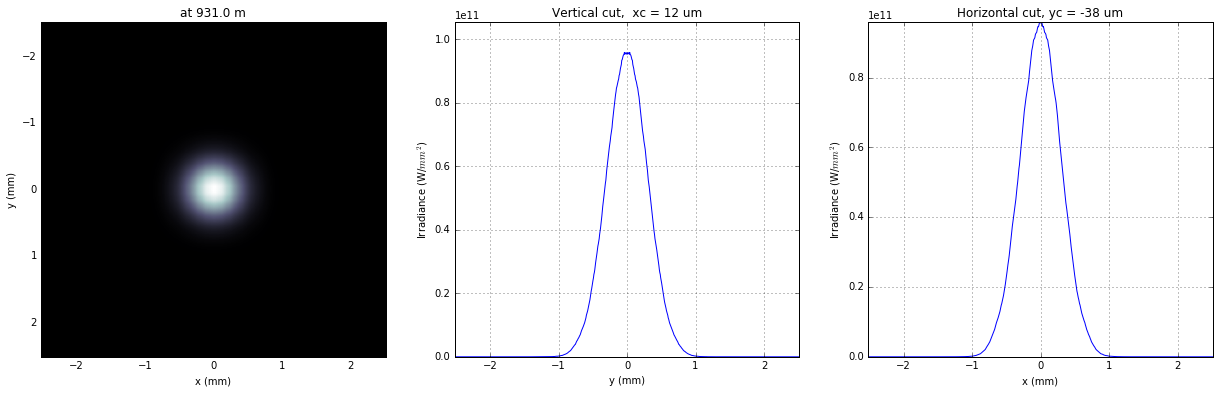

In [11]:
print '*****Collimating CRL and ideal mirror'
plot_wfront(mwf, 'at '+str(z1+z2+z3)+' m',False, False, 1e-4,1e-7,'x', True, saveDir='./'+strDataFolderName)
pylab.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
pylab.axis('tight')    
print 'FWHMx [mm], theta_fwhm [urad]:',calculate_fwhm_x(mwf)*1e3,calculate_fwhm_x(mwf)/(z1+z2)*1e6
print 'FWHMy [mm], theta_fwhm [urad]:',calculate_fwhm_y(mwf)*1e3,calculate_fwhm_y(mwf)/(z1+z2)*1e6

### Propagating through BL1 beamline. Collimating CRL and imperfect mirror

In [12]:
print ('*****Collimating CRL and imperfect mirror')
bPlotted = False
isHlog = True
isVlog = False
bSaved = False
optBL = optBL1
strBL = 'bl1'
pos_title = 'at exp hall wall'
print '*****setting-up optical elements, beamline:', strBL

if not NEW_SYNTAX: 
    bl = Beamline(optBL)
else:
    bl = optBL
print bl

if bSaved:
    out_file_name = os.path.join(strDataFolderName, fname0+'_'+strBL+'.h5')
    print 'save hdf5:', out_file_name
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print 'propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min'

*****Collimating CRL and imperfect mirror
*****setting-up optical elements, beamline: bl1
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 235.0
	Fy = 235.0
	arTr = array of size 2004002
	extTr = 1
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1001
		ny = 1001
		xFin = 0.001969
		xStart = -0.001969
		yFin = 0.001969
		yStart = -0.001969
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 55.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.002
	Dy = 0.0020936261413
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.002
	Dy = 0.0020936261413
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Opt

*****Collimating CRL and imperfect mirror
FWHMx [mm]: 0.6784899532
FWHMy [mm]: 0.697875380434
Coordinates of center, [mm]: -0.187392463265 0.0387708544686
stepX, stepY [um]: 6.4618090781 6.4618090781 

Total power (integrated over full range): 53.3003 [GW]
Peak power calculated using FWHM:         52.7227 [GW]
Max irradiance: 97.8661 [GW/mm^2]
FWHMx [mm], theta_fwhm [urad]: 0.6784899532 2.33962052828
FWHMy [mm], theta_fwhm [urad]: 0.697875380434 2.40646682908


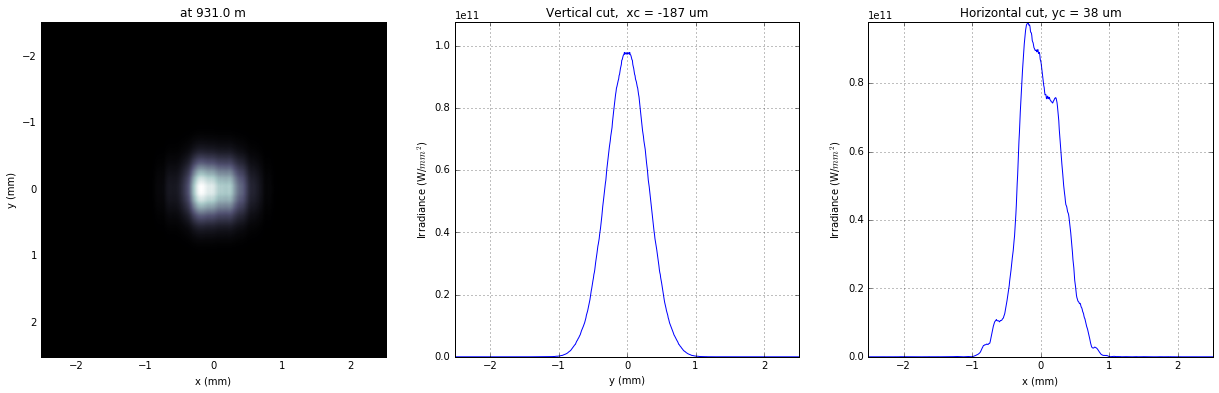

In [13]:
print ('*****Collimating CRL and imperfect mirror')
plot_wfront(mwf, 'at '+str(z1+z2+z3)+' m',False, False, 1e-4,1e-7,'x', True, saveDir='./'+strDataFolderName)
pylab.set_cmap('bone') #set color map, 'bone', 'hot', etc
pylab.axis('tight')    
print 'FWHMx [mm], theta_fwhm [urad]:',calculate_fwhm_x(mwf)*1e3,calculate_fwhm_x(mwf)/(z1+z2)*1e6
print 'FWHMy [mm], theta_fwhm [urad]:',calculate_fwhm_y(mwf)*1e3,calculate_fwhm_y(mwf)/(z1+z2)*1e6

### Propagating through BL2 beamline. Collimating CRL1, imperfect mirror, focusing CRL2

In [21]:
print ('*****Collimating CRL1, imperfect mirror, focusing CRL2')
bPlotted = False
isHlog = True
isVlog = False
bSaved = False
optBL = optBL2
strBL = 'bl2'
pos_title = 'at sample'
print '*****setting-up optical elements, beamline:', strBL
if not NEW_SYNTAX: 
    bl = Beamline(optBL)
else:
    bl = optBL
print bl

if bSaved:
    out_file_name = os.path.join(strDataFolderName, fname0+'_'+strBL+'.h5')
    print 'save hdf5:', out_file_name
else:
    out_file_name = None
    
startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print 'propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min'

*****Collimating CRL1, imperfect mirror, focusing CRL2
*****setting-up optical elements, beamline: bl2
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 235.0
	Fy = 235.0
	arTr = array of size 2004002
	extTr = 1
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1001
		ny = 1001
		xFin = 0.001969
		xStart = -0.001969
		yFin = 0.001969
		yStart = -0.001969
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 55.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.002
	Dy = 0.0020936261413
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.002
	Dy = 0.0020936261413
	ap_or_ob = a
	shape = r
	x = 0

*****Collimating CRL1, imperfect mirror, focusing CRL2
FWHMx[um]: 3.18983483347
FWHMy [um]: 3.64552552396
Coordinates of center, [mm]: 0.0 0.0
stepX, stepY [um]: 0.455690690496 0.455690690496 

Total power (integrated over full range): 44.8729 [GW]
Peak power calculated using FWHM:         38.874 [GW]
Max irradiance: 2.93824e+06 [GW/mm^2]
FWHMx [um], FWHMy [um]: 3.64552552396 3.64552552396


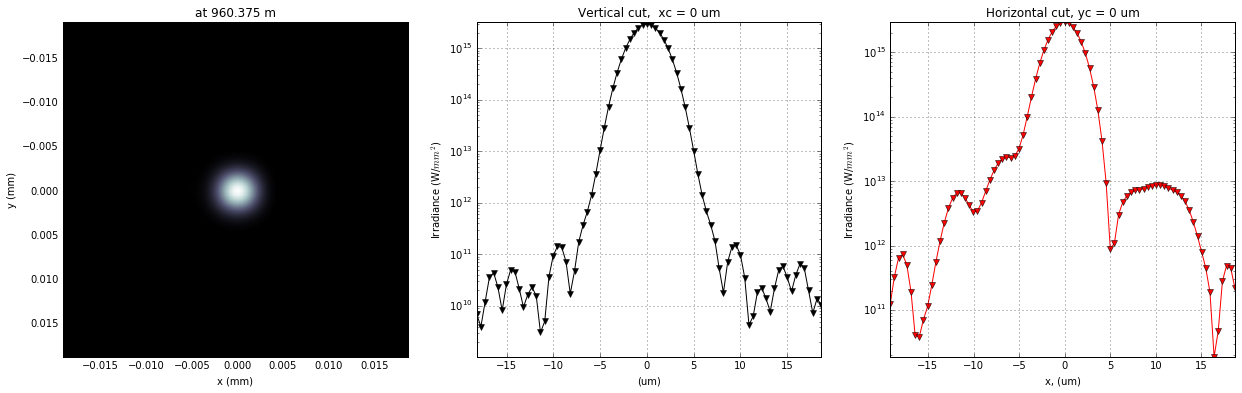

In [22]:
print ('*****Collimating CRL1, imperfect mirror, focusing CRL2')
plot_wfront(mwf, 'at '+str(z1+z2+z3+z4)+' m',True, True, 1e-4,1e-6,'x', True, saveDir='./'+strDataFolderName)
#pylab.set_cmap('bone') #set color map, 'bone', 'hot', etc
pylab.axis('tight')    
print 'FWHMx [um], FWHMy [um]:',calculate_fwhm_y(mwf)*1e6,calculate_fwhm_y(mwf)*1e6 